# Exercise 8. Mining Social Graphs

In this exercise we will conduct network analytics on a 2018 State of the Union Retweet dataset, which can be found here: https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv. We will analyse the relationship between the users both visually and using network metrics. We will follow the steps:

     1. Network creation
     2. Network visualisation
     3. Degree centrality
     4. Betweenness centrality

This notebook was inspired by the following course: https://learn.datacamp.com/courses/analyzing-social-media-data-in-python.

In [2]:
!pip install tweet-preprocessor
# Import packages
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from preprocessor.api import clean

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Import dataset
!wget -O /content/drive/MyDrive/sotu2018-rt.csv https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv

--2021-06-04 11:47:01--  https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv
Resolving assets.datacamp.com (assets.datacamp.com)... 104.18.16.147, 104.18.17.147
Connecting to assets.datacamp.com (assets.datacamp.com)|104.18.16.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1686043 (1.6M)
Saving to: ‘/content/drive/MyDrive/sotu2018-rt.csv’

/content/drive/MyDr 100%[===================>]   1.61M  --.-KB/s    in 0.06s   

2021-06-04 11:47:02 (27.0 MB/s) - ‘/content/drive/MyDrive/sotu2018-rt.csv’ saved [1686043/1686043]



In [8]:
sotu_retweets = pd.read_csv('/content/drive/MyDrive/sotu2018-rt.csv')
sotu_retweets.head()

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status-extended_tweet-full_text,quoted_status-text,quoted_status-user-screen_name,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
0,NaN,NaN,Wed Jan 31 03:51:59 +0000 2018,NaN,0,False,low,NaN,958548390052179968,958548390052179968,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,A PERFECT ANALOGY:\n\nSeveral democrats are br...,A PERFECT ANALOGY:\n\nSeveral democrats are br...,ScottPresler,"<a href=""http://twitter.com/download/iphone"" r...",RT @ScottPresler: A PERFECT ANALOGY:\n\nSevera...,1517370719813,False,MatthewJAld,NaN
1,NaN,NaN,Wed Jan 31 03:55:33 +0000 2018,NaN,0,False,low,NaN,958549287285215232,958549287285215232,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,NaN,President Trump invited families of Americans ...,RealJack,"<a href=""http://twitter.com/download/android"" ...",RT @RealJack: President Trump invited families...,1517370933730,False,broussard_sr,NaN
2,NaN,NaN,Wed Jan 31 03:09:22 +0000 2018,NaN,0,False,low,NaN,958537665334296577,958537665334296577,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,NaN,Don't you be fooled by any of his White Suprem...,UNITEDWEDREAM,"<a href=""http://twitter.com/download/iphone"" r...",RT @UNITEDWEDREAM: Don't you be fooled by any ...,1517368162841,False,CLSTEPHANY,NaN
3,NaN,NaN,Wed Jan 31 02:36:19 +0000 2018,NaN,0,False,low,NaN,958529347828305921,958529347828305921,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,NaN,Uh-oh. Our president mentioned the FIRST and S...,TomiLahren,"<a href=""http://twitter.com/download/iphone"" r...",RT @TomiLahren: Uh-oh. Our president mentioned...,1517366179793,False,DAWNSTUTESMAN,NaN
4,NaN,NaN,Wed Jan 31 02:46:24 +0000 2018,NaN,0,False,low,NaN,958531885424173057,958531885424173057,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,"Tonight isn't about memos, fake news, free thi...","Tonight isn't about memos, fake news, free thi...",TomiLahren,"<a href=""http://twitter.com/download/android"" ...","RT @TomiLahren: Tonight isn't about memos, fak...",1517366784803,False,SCischk,NaN


In [9]:
# Restrict the dataset to tweets from FoxNews or tweets that foxnews retweeted
# 'user-screen_name': who retweeted
# 'retweeted_status-user-screen_name': who created the original tweet
sotu_retweets_Fox=sotu_retweets[(sotu_retweets['user-screen_name']=='FoxNews') | (sotu_retweets['retweeted_status-user-screen_name']=='FoxNews')]

In [10]:
sotu_retweets_Fox.head()

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status-extended_tweet-full_text,quoted_status-text,quoted_status-user-screen_name,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
52,NaN,NaN,Wed Jan 31 03:14:11 +0000 2018,NaN,0,False,low,NaN,958538876695523328,958538876695523328,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,".@POTUS: ""Terrorists who do things like place ...",".@POTUS: ""Terrorists who do things like place ...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""Terrorists who do thing...",1517368451652,False,coachfoster15,NaN
55,NaN,NaN,Wed Jan 31 02:52:54 +0000 2018,NaN,0,False,low,NaN,958533520988753923,958533520988753923,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,".@POTUS: ""For decades, open borders have allow...",".@POTUS: ""For decades, open borders have allow...",FoxNews,"<a href=""http://twitter.com/#!/download/ipad"" ...","RT @FoxNews: .@POTUS: ""For decades, open borde...",1517367174752,False,VoseJim,NaN
58,NaN,NaN,Wed Jan 31 03:06:20 +0000 2018,NaN,0,False,low,NaN,958536901211967489,958536901211967489,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,".@POTUS: ""We celebrate our police, our militar...",".@POTUS: ""We celebrate our police, our militar...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""We celebrate our police...",1517367980660,False,slewis8353,NaN
73,NaN,NaN,Wed Jan 31 03:16:53 +0000 2018,NaN,0,False,low,NaN,958539556155994112,958539556155994112,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,.@POTUS: “Let’s begin tonight by recognizing t...,.@POTUS: “Let’s begin tonight by recognizing t...,FoxNews,"<a href=""http://twitter.com/download/android"" ...",RT @FoxNews: .@POTUS: “Let’s begin tonight by ...,1517368613648,False,TravarL,NaN
84,NaN,NaN,Wed Jan 31 03:36:51 +0000 2018,NaN,0,False,low,NaN,958544581058064384,958544581058064384,NaN,NaN,NaN,NaN,NaN,False,en,NaN,False,0,NaN,NaN,NaN,NaN,NaN,0,0,False,".@POTUS: ""We repealed the core of disastrous #...",".@POTUS: ""We repealed the core of disastrous #...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""We repealed the core of...",1517369811678,False,kujayhawksone66,NaN


In [11]:
# Foxnews retweeted once from FoxBusiness
sotu_retweets_Fox[(sotu_retweets_Fox['user-screen_name']=='FoxNews')][['retweeted_status-user-screen_name', 'text']]

,retweeted_status-user-screen_name,text
2144,FoxBusiness,RT @FoxBusiness: WATCH: President Donald J. Tr...


In [12]:
# Foxnews was retweeted 128 times
sotu_retweets_Fox[(sotu_retweets_Fox['retweeted_status-user-screen_name']=='FoxNews')][['user-screen_name', 'text']]

,user-screen_name,text
52,coachfoster15,"RT @FoxNews: .@POTUS: ""Terrorists who do thing..."
55,VoseJim,"RT @FoxNews: .@POTUS: ""For decades, open borde..."
58,slewis8353,"RT @FoxNews: .@POTUS: ""We celebrate our police..."
73,TravarL,RT @FoxNews: .@POTUS: “Let’s begin tonight by ...
84,kujayhawksone66,"RT @FoxNews: .@POTUS: ""We repealed the core of..."
...,...,...
2150,TimTheTruckerCA,RT @FoxNews: .@POTUS's Cabinet arrives. #SOTU ...
2210,ggary59,RT @FoxNews: 'Legend from Louisiana': Trump Ho...
2218,Chelseax05,"RT @FoxNews: .@POTUS: ""Working with the Senate..."
2237,rob_radams20,"RT @FoxNews: .@POTUS: ""Let's support working f..."


## 1. Network creation

In [13]:
# Create retweet network where each edge starts at the user who retweeted the Tweet
# and ends at the user who created it. The network is therefore directed.

G_rt = nx.from_pandas_edgelist(
    sotu_retweets_Fox,
    source = 'retweeted_status-user-screen_name',
    target = 'user-screen_name',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 130
Edges in RT network: 129


The retweet network can be used which users are the most retweeted by others. Those would also be considered the most influential which is important for instance for sponsoring campaigns.

Also it can be used to see which users distribute the most (not own) content to others. Knowing them and making sure they distribute particular tweet of a company (e.g. job opening) can help reach many unknown users.

There are 130 nodes in the network, 128 of them retweeted FoxNews, 1 is FoxNews and 1 is FoxBusiness. 

In [14]:
 # Number of edges adjacent to a node
G_rt.degree['FoxNews']

129

In [15]:
G_rt.edges()

OutEdgeView([('FoxNews', 'coachfoster15'), ('FoxNews', 'VoseJim'), ('FoxNews', 'slewis8353'), ('FoxNews', 'TravarL'), ('FoxNews', 'kujayhawksone66'), ('FoxNews', 'EblingJr'), ('FoxNews', 'LaurelT1'), ('FoxNews', 'SherryWhy1'), ('FoxNews', 'JeSuisDog'), ('FoxNews', 'LorriStringer'), ('FoxNews', 'TomReed72363098'), ('FoxNews', 'bobbypick'), ('FoxNews', 'Texas_Trump'), ('FoxNews', 'dnjma5'), ('FoxNews', 'ChrisFi19702048'), ('FoxNews', '2Run26'), ('FoxNews', 'Lynnmorrisdown1'), ('FoxNews', 'sjlev_lvgd'), ('FoxNews', 'astepp37'), ('FoxNews', 'jackson5213'), ('FoxNews', 'GetOnTRUMPTrain'), ('FoxNews', 'DeJonXIII'), ('FoxNews', 'Deplorablesss'), ('FoxNews', 'resterkat57'), ('FoxNews', 'aburgher'), ('FoxNews', 'AdvertisingLaw'), ('FoxNews', 'RicoColon1'), ('FoxNews', 'Karen_Becker_Go'), ('FoxNews', 'SASHATAZLEA'), ('FoxNews', 'stillcricket'), ('FoxNews', 'Pperezz21'), ('FoxNews', 'TheGhostImpala'), ('FoxNews', 'lisastewart59'), ('FoxNews', 'Heart4Missions'), ('FoxNews', 'WEdwarda'), ('FoxNews'

## 2. Network visualisation

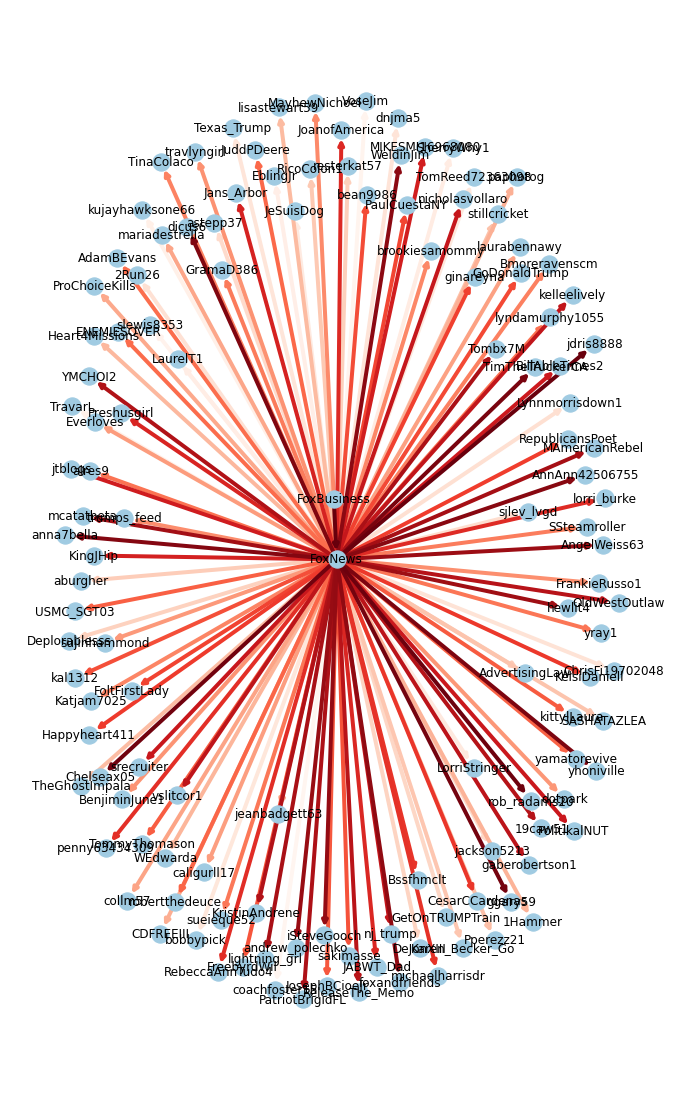

In [16]:
# Create a graph that has as nodes the users in the dataset (both tweet creators and retweet)
# The size of the node is equal to its in_degree centrality (i.e. retweets)

plt.figure(figsize=(12,20)) 
# Draw the network
    # k controls the distance between the nodes and varies between 0 and 1
    # iterations is the number of times simulated annealing is run
    # default k =0.1 and iterations=50
    # Increase k to move nodes farther apart.
    # #A0CBE2 HEx of blue https://www.google.com/search?q=color+picker
    #edge_cmap (Matplotlib colormap, optional (default=None)) – Colormap for mapping intensities of edges
    #If numeric values are specified they will be mapped to colors using the edge_cmap and edge_vmin,edge_vmax parameters.
    #https://matplotlib.org/examples/color/colormaps_reference.html
    #width (float, optional (default=1.0)) – Line width of edges
pos = nx.spring_layout(G_rt,k=0.20,iterations=20)
colors = range(129)
nx.draw_networkx(G_rt,pos,arrows=True, node_color='#A0CBE2', edge_color=colors,
        width=4, edge_cmap=plt.cm.Reds, with_labels=True)

# Turn off axis as it looks nicer
plt.axis('off')
plt.show()

## 3. Degree centrality

In [17]:
# Create a retweet network for the whole dataset

G_rt_full = nx.from_pandas_edgelist(
    sotu_retweets,
    source = 'retweeted_status-user-screen_name', 
    target = 'user-screen_name',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in RT network:', len(G_rt_full.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt_full.edges()))

Nodes in RT network: 2287
Edges in RT network: 2340


In-degree shows the number of edges going into each node, while out-degree stands for the number of edges going out of the node. Here out-degree is the number of retweets by other users while in-degree is how many times the user retweeted.

In [18]:
# Generate in- and out-degree centrality for retweets as dictionaries
rt_centrality_in = nx.in_degree_centrality(G_rt_full)
rt_centrality_out = nx.out_degree_centrality(G_rt_full)

# Store in-degree-centralities in DataFrame
rt_in = pd.DataFrame(list(rt_centrality_in.items()), columns = ['screen_name', 'in_degree_centrality'])
rt_out = pd.DataFrame(list(rt_centrality_out.items()), columns = ['screen_name', 'out_degree_centrality'])

# Print first five results in descending order of centrality
#The degree centrality values are normalized by dividing by 
#the maximum possible degree in a simple graph n-1 where n is the number 
#of nodes in G.
print('Top Retweeters')
#print(rt_in.sort_values('in_degree_centrality', ascending = False).head())
print(rt_in.sort_values('in_degree_centrality', ascending = False).head())
print('')
print('Top Retweeted')
print(rt_out.sort_values('out_degree_centrality', ascending = False).head())


Top Retweeters
         screen_name  in_degree_centrality
475         nljac000              0.002187
204          aedaw9i              0.001750
417          CiAnDy3              0.001750
302  SteveJa39296543              0.001750
746    c5hardtop1999              0.001750

Top Retweeted
      screen_name  out_degree_centrality
83        FoxNews               0.055993
37     WhiteHouse               0.031059
0    ScottPresler               0.029746
6      TomiLahren               0.019685
131  KyleKulinski               0.017060


## 4. Betweenness centrality

In [19]:
# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt_full)

column_names = ['screen_name', 'betweenness_centrality']
# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
print(rt.sort_values('betweenness_centrality', ascending = False).head())

        screen_name  betweenness_centrality
83          FoxNews                0.000026
28   Public_Citizen                0.000009
205     ChristiChat                0.000005
120      guypbenson                0.000005
361    johncardillo                0.000004


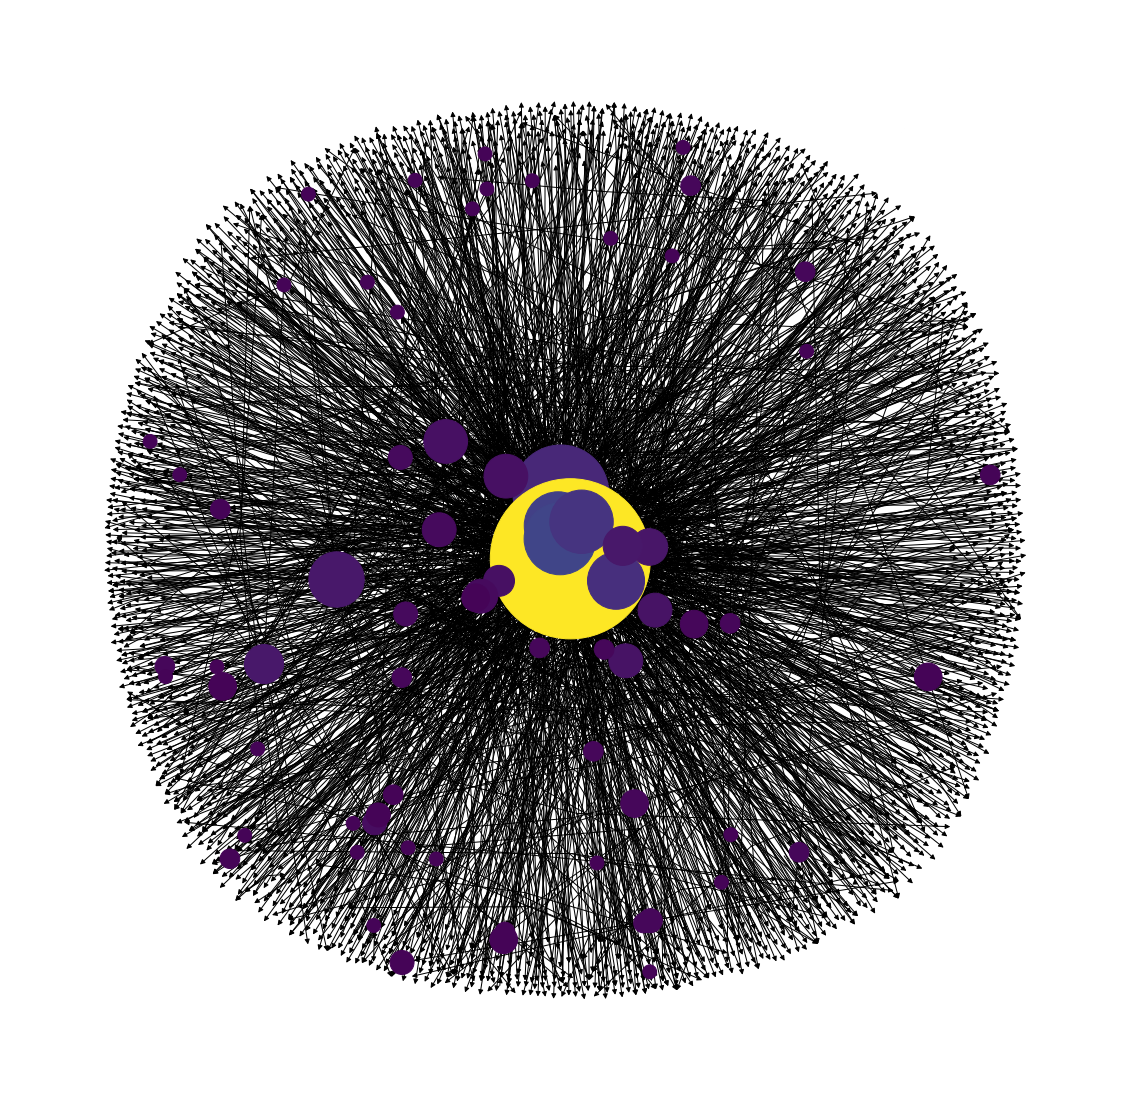

In [20]:
# The node size stands for the betweenness centrality, the node color for the degree centrality

node_color = [200000000* G_rt_full.out_degree(v) for v in G_rt_full]
node_size =  [v * 1000000000 for v in rt_centrality.values()]
#pos = nx.spring_layout(G_rt_full,k=0.20,iterations=20)
#VIRIDIS color map
#https://bids.github.io/colormap/
plt.figure(figsize=(20,20))
nx.draw_networkx(G_rt_full,with_labels=False,
                 node_size=node_size, node_color=node_color )
plt.axis('off')
plt.show()

In [ ]:
import matplotlib
matplotlib.__version__

'3.1.1'

The yellow node is FoxNews as it has both high in-degree and betweenness. This means that it is both important source of information and a user through which a lot of information flows. Generally, nodes with higher betweenness can be seen as the centers of topic clusters. If you remove them, the topic community may brake down.

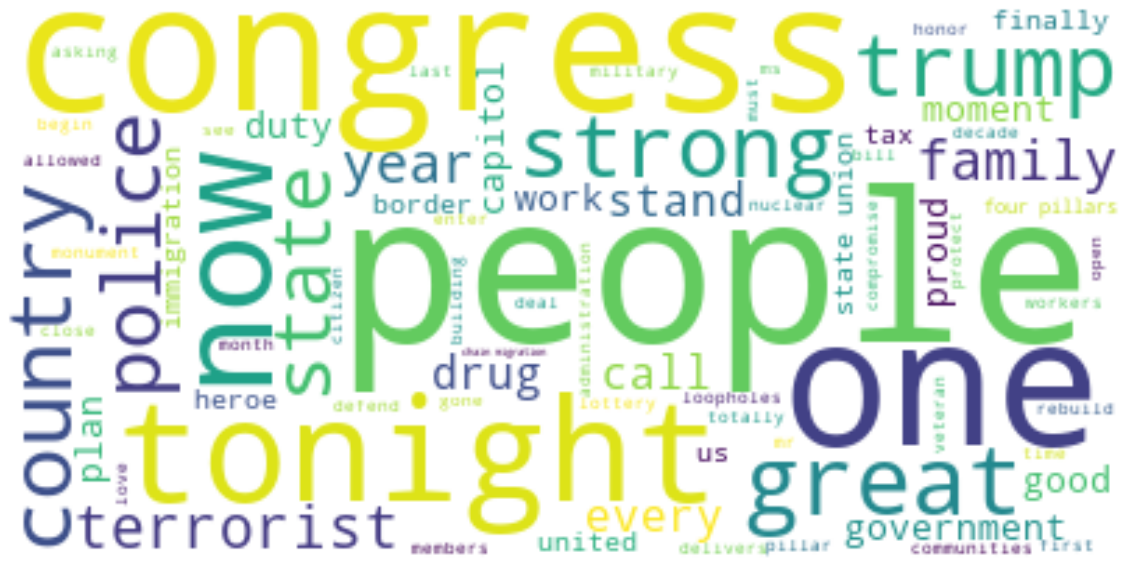

In [21]:
# Clean the texts from Twitter-specific parts and join all tweets together
all_text = " ".join(clean(t).lower() for t in sotu_retweets_Fox.text)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["https", "amp", "america", "american", "americans", "president", "will", "address", "new"])
plt.figure(figsize=(20,20))

# Generate a word cloud 
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(all_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()